In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py
import pickle

import logging

import gym
import numpy as np
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

sys.path.insert(1, "/home/eric/Code/chai/test/learning-from-human-preferences")
sys.path.insert(2, "/home/eric/Code/chai/test/learning-from-human-preferences/drlhp")

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import easy_tf_log
#     from drlhp import reward_predictor
    from drlhp.reward_predictor_core_network import net_cnn
    from drlhp.HumanPreferencesEnvWrapper import _make_reward_predictor

In [3]:
ckpt_dir = Path('/home/eric/Code/chai/test/learning-from-human-preferences/runs/pong_45cb953/reward_predictor_checkpoints')
log_dir = Path('logs')
logger = logging.getLogger("testytest")

obs_shape = (84, 84, 4)

In [4]:
rp = _make_reward_predictor(reward_predictor_network=net_cnn,
                           log_dir=log_dir,
                           obs_shape=obs_shape,
                           logger=logger,
                           checkpoint_dir=ckpt_dir)

RewardPredictorEnsemble created
RewardPredictorEnsemble initialized


In [6]:
rp.reward(np.random.randn(1, 84, 84, 4))

array([0.], dtype=float32)

In [2]:
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [11]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [14]:
env_id = "PongNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [15]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [48]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

def reward_model_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model.reward(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model.reward(obs_copy)
    return abs(baseline[0] - modified[0])**2


In [57]:
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0] == 1.0:
        break

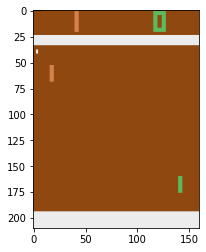

In [58]:
plt.imshow(env.get_images()[0])

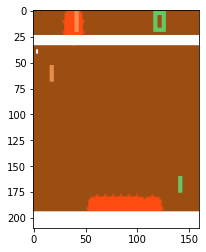

In [59]:
radius = 5
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    m = max(r, g, b)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region / m
    spot[:, :, 1] = g * region / m
    spot[:, :, 2] = b * region / m
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)


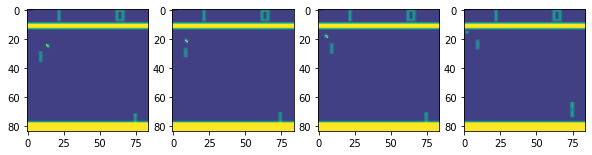

In [62]:
plt.figure(figsize=(10, 4))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

In [64]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

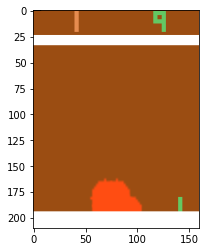

In [69]:
radius = 7
stride = 6

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/pong/pong_drlhp_reward_model_saliency.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        locs = max_k(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
#         screenshot = screenshot * 0.4
        for loc in locs:
                r, g, b, a = matplotlib.cm.hot(value)
                m = max(r, g, b)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region / m
                spot[:, :, 1] = g * region / m
                spot[:, :, 2] = b * region / m
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


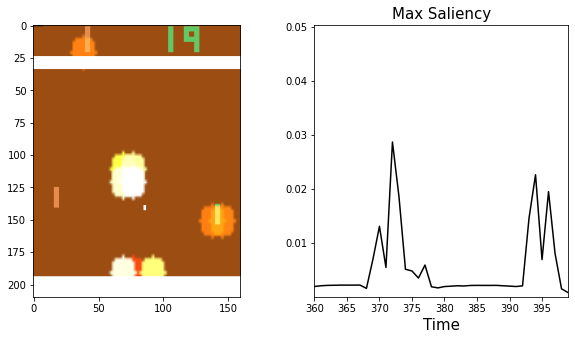

In [79]:
radius = 5
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
ax2.set_xlabel("Time", fontsize=15)
ax2.set_title("Max Saliency", fontsize=15)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
timeseries = ax2.plot([], [], c='black')[0]
max_saliencies = []
with writer.saving(fig, "../videos/pong/pong_drlhp_reward_model_saliency_withtimeseries.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        max_value = pairs[0][1]
        max_saliencies.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        ax2.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
#         ax2.set_yscale('log')
        ax2.set_ylim(min(max_saliencies), 1.1*max(max_saliencies))
        timeseries.set_data(list(range(i+1))[-40:], max_saliencies[-40:])
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

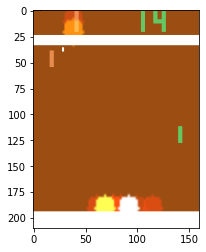

In [78]:
radius = 5
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
max_value = pairs[0][1]
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value / max_value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)